# 23 - Plug-and-Play Estimators

So far, we've seen how to debias our data in the case where the treatment is not randomply assigned, which results in confounding bias. That helps us with the identification problem in causal inference. In other words, once the units are exangable, or \\( Y(0), Y(1) \perp X\\), it become possible to learn treatment effect. But we are far from done. 


## Problem Setup

Let's recall our setup of interest. Given the potential outcomes, we can define the individual treatment effect as the difference between the potential outcomes.

$
\tau_i = Y_i(1) − Y_i(0),
$

or, the continous treatment case, \\(\tau_i = \partial Y(t)\\), where \\(t\\) is the treatment variable. Of course, we can never observe the individual treatment effect, because we only get to see the one of potential outcomes

$
Y^{obs}_i(t)= 
\begin{cases}
Y_i(1), & \text{if } t=1\\
Y_i(0), & \text{if } t=0
\end{cases}
$

We can define the average treatment effect (ATE) as

$
\tau = E[Y_i(1) − Y_i(0)] = E[\tau_i]
$

and the conditional average treatment effect (CATE) as

$
\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]
$

In Part I of this book, we've focused mostly on the ATE. Now, we are interested in the CATE. The CATE is usefull for personalising a decision making process. For example, if you have a drug as the treatment \\(t\\), you want to know which type of patients are more responsive to the drug (higher CATE) and if there are some type of patient with a negative response (CATE < 0). 

We've seen how to estimate the CATE using a linear regression with interactions between the treatment and the the features

$
y_i = \beta_0 + \beta_1 t_i + \beta_2 X_i + \beta_3 t_i X_i + e_i.
$

If we estimate this model, we can get estimates for \\(\tau(x)\\)

$
\hat{\tau}(x) = \hat{\beta}_1 + \hat{\beta}_3 t_i X_i
$

Still, the linear models has some drawbacks. The main one being the linearity assumption on \\(X\\). Notice that you don't even care about \\(\beta_2\\) on this model. But if the features \\(X\\) are not linearly impacting the outcome, your estimates of the causal parameters \\(\beta_1\\) and \\(\beta_3\\) will be off. 

It would be great if we could replace the linear model by a more flexible machine learning model. We could even plug the treatment as a feature to a ML model, like boosted trees or a neural network

$
y_i = M(X_i, T_i) + e_i
$

but from there, it is not clear how we can get treatment effect estimates, since this model will output \\(\hat{y}\\) predictions, not \\(\hat{\tau(x)}\\) predictions. Ideally, we would use a machine learning regression model that, instead of minimising the outcome MSE

$
E[(Y_i - \hat{Y}_i)^2]
$

would minimise the treatment effect MSE

$
E[(\tau(x)_i - \hat{\tau}(x)_i)^2] = E[(Y_i(1) - Y_i(0) - \hat{\tau}(x)_i)^2].
$

However, this criterion is what we call infesable. Again, the problem here is that \\(\tau(x)_i\\) is not obervable, so we can't optimize it direcly. This puts us in a though spot... Let's try to simplify it a bit.

## Target Tranformation

Suppose your treatment is binary. Let's say you are an investment firm testing the effectivness of sending a financial education email. You hope the email will make people invest more. Also, let's say you did a randomized study where 50% of the customers got the email and the other 50% didn't. 

Here is the crazy idea: let's transform the outcome variable by multiplying it with the treatment.

$
Y^*_i = 2 Y_i * T_i - 2 Y_i*(1-T_i)
$


So, if the unit was treated, you would take the outcome and multiply by 2. If it wasn't treated, you would take the outcome and multiply it by -2. For example, if one of your customers invested BRL 2000,00 and got the email, the tranformed target would be 4000. However, if he or she didn't get the email, it would be -4000. 

This seem very odd, because you are saying that the effect of the email can be a negative number, but bare with me. If we do a little bit of math, we can see that, on average or in expectation, this tranformed target will be the treatment effet. Because of random assignment, we have that \\(T \perp Y(1), Y(1)\\), which is our old unconfoundness friend. That immplies that \\(E[T, Y(t)]=E[T]*E[Y(t)]\\), which is the definition of independende. Also, we know that \\(Y_i*T_i = Y_(1)i*T_i\\) and \\(Y_i*(1-T_i) = Y_(0)i*T_i\\), because the treatment is what materialize one or the other potential outcomes. With that in mind, let's take the expected value of \\(Y^*_i\\) and see what we end up with. 

$
\begin{align}
E[Y^*_i|X_i=x] &= E[2 Y(1)_i * T_i - 2 Y(0)_i*(1-T_i)|X_i=x] \\
&= 2E[Y(1)_i * T_i | X_i=x] - 2E[Y(0)_i*(1-T_i)|X_i=x]\\
&= 2E[Y(1)_i| X_i=x] * E[ T_i | X_i=x] - 2E[Y(0)_i| X_i=x]*E[(1-T_i)|X_i=x] \\
&= 2E[Y(1)_i| X_i=x] * 0.5 - 2E[Y(0)_i| X_i=x]*0.5 \\ 
&= E[Y(1)_i| X_i=x] - E[Y(0)_i| X_i=x] \\
&= \tau(x)_i
\end{align}
$

So, this apparently crazy idea ended up being an unbiased estimate of the individual treatment effect \\(\tau(x)_i\\). Now, we can replace our infisible optimization criterion with 

$
E[(Y^*_i - \hat{\tau}(x)_i)^2]
$

In simpler terms, all we have to do is use any regression machine learning model to predict \\(Y^*_i\\) and this model will output treatment effect predictions. 

Now that we've solved the simple case, what about the more complicated case, where treatment is not 50% 50%, or not even randomly assigned? As it turns out, the answer is a bit more complicated, but not much. First, if we don't have random assignment, we need at least conditional independence \\(T \perp Y(1), Y(1) | X\\). That is, controling for \\(X\\), \\(T\\) is as good as random. With that, we can generalize the tranformed target to

$
Y^*_i = Y_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}
$

where \\(e(X_i)\\) is the propensity score. So, if the treatment is not 50% 50%, but a probability \\(p\\), all you have to do is replace the propensity score in the above formula with \\(p\\). If you the treatment is not random, then you have to use the propensity score, either stored or estimated. 

If you take the expectation of this, you will see that it also matches the treatment effect. the proof is left as an exercise to the reader. Just kidding, here it is. Its a bit cumbersome, so feel free to skip it.  

<br></br>
<details>
<summary>> Click for Proof</summary>
$
\begin{align}
E[Y^*_i|X_i=x] &= E\big[Y_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big] \\
&= E\big[Y_i T_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))} + Y_i (1-T_i) * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big]\\
&= E\big[Y(1)_i * \dfrac{T_i(1 - e(X_i))}{e(X_i)(1-e(X_i))} | X_i=x\big] - E\big[Y(0)_i * \dfrac{(1-T_i)e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big]\\
&= \dfrac{1}{e(X_i)} E[Y(1)_i * T_i|X_i=x] - \dfrac{1}{1-e(X_i)} E[Y(0)_i * (1-T_i)| X_i=x]\\
&= \dfrac{1}{e(X_i)} E[Y(1)_i|X_i=x] * E[T_i|X_i=x] - \dfrac{1}{1-e(X_i)} E[Y(0)_i|X_i=x] * E[(1-T_i)| X_i=x]\\
&= E[Y(1)_i|X_i=x] - E[Y(0)_i|X_i=x]\\
&= \tau(x)_i
\end{align}
$
</details>

As always, I think this will become much more concrete with an example. Again, consider the investment emails we've send trying to make people convert to a product we wish to sell. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast

In [2]:
email = pd.read_csv("./data/invest_email_rnd.csv")
email.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,1,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,1,0,1,1
3,39.7,2326.37,15657.97,6345.20,1,1,1,0
4,35.3,2787.26,27074.44,14114.86,1,1,1,0


Our goal here is one of personalization. Lets focus on email-1. We wish to send it only to those customers who will respond better to it. In other words, we wish to estimate the conditional average treatment effect of email-1

$
E[Converted(1)_i - Converted(0)_i|X_i=x] = \tau(x)_i
$

Once we have a way of estimating \\(\tau(x)_i\\), we will use this estimates to decide who will we send the email to. 

But first, let's break out dataset into a training and a validation set. We will estimate \\(\tau(x)_i\\) on one set and evaluate the estimates on the other.

In [3]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
train, test = train_test_split(email, test_size=0.4)
print(train.shape, test.shape)

(9000, 8) (6000, 8)


Now, we will apply the target transformation we've just learned. Since the emails where randomly assigned (although not on a 50% 50% basis), we don't need to worry about the propensity score. Rather, it is constant and equal to the treatment probability.

In [4]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

ps = train[T].mean()

y_star_train = train[y] * (train[T] - ps)/(ps*(1-ps))

With the tranformed target, we can pick any ML regression algorithm to predict it. Lets use boosted trees here.

In [5]:
from lightgbm import LGBMRegressor

np.random.seed(123)
cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)
cate_learner.fit(train[X], y_star_train);

This model can now estimate \\(\tau(x)_i\\). In other words, what it outputs is \\(\hat{\tau}(x)_i\\). For example, if we make predictions on the test set, we will see that some units have higher CATE than others. For example, customer 6958 has CATE of 0.1, meaning the probability he or she will buy our investment product is predicted to increases by 0.1 if we send the email to this customer. In contrast, for customer 3903, the probability of buying the product is predicted to increase just 0.04.

In [6]:
test_pred = test.assign(cate=cate_learner.predict(test[X]))
test_pred.head()

,age,income,insurance,invested,em1,em2,em3,converted,cate
6958,40.9,4486.14,37320.33,12559.25,0,0,1,0,0.105665
7534,42.6,6386.19,13270.47,29114.42,0,0,1,0,0.121922
2975,47.6,1900.26,25588.72,2420.39,0,0,1,0,0.034161
3903,41.0,5802.19,57087.37,20182.20,1,0,1,1,0.046805
8437,49.1,2202.96,5050.81,9245.88,1,0,1,0,-0.009099


To evaluate how good is this model, we can show the cummulative gain curves. 

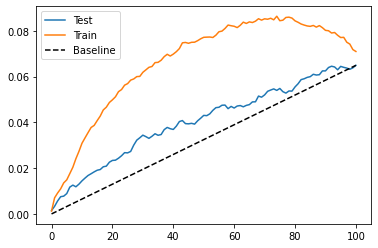

In [7]:
gain_curve_test = cumulative_gain(test_pred, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[X])), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();

As we can see, this plug and play estimator is better than random on the test set. Still, it looks like it is overfitting a lot, since the performance on the training set is much better than that of the test set. 

That is actually on of its biggest downside. With this target tranformation, you do get a lot of simplicity, sice you can just tranform the target and use any ML estimator to predict heterogeneous treatment effects. The cost of it is that you get a lot of variance. That's because the tranformed target is a very noisy estimate of the individual treatment effect and that variance gets tranfered to your estimation. This is a huge problem if you don't have a lot of data, but it is less of a problem in big data applications, where you are dealing with more than 1MM samples. 

## The Continuous Treatment Case

Another obvious downside of the target tranformation method is that is only works for discrete or binary treatments. This is something you see a lot in the causal inference literature. Most of the research is done for the binary treatment case, but you don't find a lot talking about  continuous treatments. That bothered me a lot, because in the industry, continuous treatments are everywhere, mostly in the form of prices you need to optimize. So, even though I counldn't find anything regarthing target tranformations for continuous treatment, I came up with something that works in practice. Just keep in mind that I don't have a super solid econometric research around it.

To motivate it, let's go back to the ice cream sales example. There, we where tasked with the problem of estimating demand elasticity to price so that we can better set the ice cream prices to optimize our revenues. Recall that evet sample in the dataset is a day and we wish know when people are less sensitive to price increases. Also, recall that prices are randomly assignes in this dataset, which means we don't need to worry about confounding bias.

In [14]:
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv") # loads random data

In [15]:
prices_rnd.head()

,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


As before, let's start by separating our data into training and a testing set.

In [16]:
np.random.seed(123)
train, test = train_test_split(prices_rnd, test_size=0.3)
train.shape, test.shape

((3500, 5), (1500, 5))

Now is where we need a little bit of creativity. For the discrete case, the conditional average treatment effect is given by how much the outcome changes when we go from untreated to treated, conditioned on units characteristics \\(X\\). 

$
\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]
$

In plain english, this is estimating the impact of the treatment on different unit profiles, where profiles are defined using the features \\(X\\). For the continous case, we don't have that on-off swich. Units are not treated on untreated. Rather, they are all treated, but with different intensities. Therefore, we can't talk about the effect of giving the treatment. Rather, we need to speak in terms of increasing the treatment. In other words, we wish to know how the outcome would change if we increase the treatment by some ammount. This is like estimating the partial derivative of the outcome function \\(Y\\) on the treatment \\(t\\). And because we wish to know that for each group (the CATE, not the ATE), we condition on the features \\(X\\)

$
\tau(x) = E[\partial Y_i(t)|X] = E[\tau_i|X]
$

How can we estimate that? First, let's consider the easy case, where the outcome is linear on the treatment. Suppose you have two types of days: hot days (yellow) and cold days (blue). On cold days people are more sensitive to price increases. Also, as price increases, demand falls linearly.

![img](./data/img/plug-and-play-estimators/linear-case.png)

In this case, the CATE will be the slope of each demand line. These slopes will tell us how much demand will fall if we increase price by any ammount. If this relationship is indeed linear, we can estimate those elasticities with the coeficient of a simple linear regression estimates on hot days and on cold days separatly. 

$$
\hat{\tau(x)} = Cov(Y_i, T_i)/Var(T_i) = \dfrac{\sum(Y_i- \bar{Y})(T_i - \bar{T})}{\sum (T_i - \bar{T})^2}
$$

We can be inspired by this estimator and think what it would it be like for and individual unit. In other words, what if we have that same thing up there, defined for each day. In my head, it would be something like this:

$
Y^*_i = (Y_i- \bar{Y})\dfrac{(T_i - \bar{T})}{\sigma^2_T}
$

In plain English, we would tranform the original target by subtracting the mean from it, then we would multiply it by the treatment, from which we've also subracted the mean from. Finally, we would divide it by the treatment variance. Alas, we have a target tranformation for the continuous case. The questin now is does it work?

As a matter of fact it does and we can go over a similar proof for why it works, just like we did in the binary case. First, lets call

$
V_i = \dfrac{(T_i - \bar{T})}{\sigma^2_T}
$

notice that \\(E[V_i|X_i=x]=0\\) because under random assignment \\(E[T_i|X_i=x]=\bar{T}\\). In other words, for every region of X, \\(E[T_i]=\bar{T}\\). Also \\(E[T_i V_i | X_i=x]=1\\) because \\(E[T_i(T_i - \bar{T})|X_i=x] = E[(T_i - \bar{T})^2|X_i=x]\\), which is the treatment variance. Finally, under conditional independence (wich we get for free in the random treatment assignment case), \\(E[T_i e_i | X_i=x] = E[T_i | X_i=x] E[e_i | X_i=x]\\).

To show that this target tranformation works, we need to remember that we are estimating the parameter for a local linear model

$
Y_i = \alpha + \beta T_i + e_i | X_i=x
$

In our example, those would be the linear models for the hot and cold days. Here, we are interested in the \\(\beta\\) parameter, wich is our conditional elasticity or CATE. With all that, we can pove that

$
\begin{align}
E[Y^*_i|X_i=X] &= E[(Y_i-\bar{Y})V_i | X_i=x] \\
&= E[(\alpha + \beta T_i + e_i - \bar{Y})V_i | X_i=x] \\
&= \alpha E[V_i | X_i=x] + \beta E[T_i V_i | X_i=x] + E[e_i V_i | X_i=x] \\
&= \beta + E[e_i V_i | X_i=x] \\
&= \beta = \tau(x)
\end{align}
$

Bare in mind that this only works when the treatment is randomized. For non randomized treatment, we have to replace \\(\bar{T}\\) by \\(M(X_i)\\), where \\(M\\) is a model that estimates \\(E[T_i|X_i=x]\\). 

$
Y^*_i = (Y_i- \bar{Y})\dfrac{(T_i - M(T_i))}{(T_i - M(T_i))^2}
$

This will make sure that the term \\(\alpha E[V_i | X_i=x]\\) in the third line vanished to zero and that the term \\(E[T_i V_i | X_i=x]\\) goes to 1. Notice that you don't actualy need \\(E[T_i V_i | X_i=x]\\) to go to 1 if you just want to order units in terms of treatded effect. In other words, if you just want to know in which days demand is more sensitive to price increases but you don't need to know by how much, it doesn't matter if the \\(\beta\\) estimates are scaled up or down. If that is the case, you can ommit the denominator.

$
Y^*_i = (Y_i- \bar{Y})(T_i - M(T_i))
$

If all that math seems tiresome, don't worry. The codo is actually very simple. Once again, we trainform our traning target with the formulas seen above. Here, we have random treatment assignment, so we don't need to build a model that predicts prices

In [11]:
y_star_cont = ((train["price"] - train["price"].mean())
               *(train["sales"] - train["sales"].mean())
               /train["price"].std())

Then, just like before, we fit a regression ML model to predict that target. 

In [12]:
cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)

cate_learner.fit(train[["temp", "weekday", "cost"]], y_star_cont)

cate_test_transf_y = cate_learner.predict(test[["temp", "weekday", "cost"]])

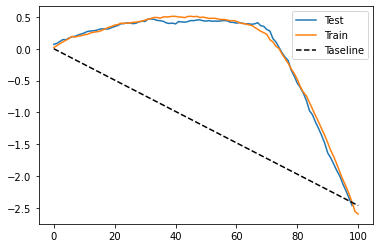

In [13]:
gain_curve_test = cumulative_gain(test.assign(cate=cate_test_transf_y),
                                "cate", y="sales", t="price")

gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[["temp", "weekday", "cost"]])),
                                   "cate", y="sales", t="price")


plt.plot(gain_curve_test, label="Test")
plt.plot(gain_curve_train, label="Train")
plt.plot([0, 100], [0, elast(test, "sales", "price")], linestyle="--", color="black", label="Taseline")
plt.legend();